In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, col, to_timestamp, year, month, day, hour, last, first, coalesce
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import sys  # Ensure sys is included for maxsize

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [0]:
spark = SparkSession.builder.appName("SSTPrediction").getOrCreate()

In [0]:
file_path_1 = "/mnt/2024-team8/Chunk-0-Cleaned-unnormalized-ERA5-82-23-three-hrs.csv"
file_path_2 = "/mnt/2024-team8/Chunk-1-Cleaned-unnormalized-ERA5-82-23-three-hrs.csv"
#file_path_3 = "/mnt/2024-team8/Chunk-2-Cleaned-Processed-ERA5-82-23-three-hrs.csv"

df1 = spark.read.csv(file_path_1, header=True, inferSchema=True)
df2 = spark.read.csv(file_path_2, header=True, inferSchema=True)
#df3 = spark.read.csv(file_path_3, header=True, inferSchema=True)

In [0]:
df = df1.union(df2)
#df = df_merged.union(df3)

In [0]:
df = df.withColumn("time", to_timestamp("time")).orderBy("time", "latitude", "longitude")


In [0]:
df = df.withColumn("year", year("time"))
df = df.withColumn("month", month("time"))
df = df.withColumn("day", month("time"))
df = df.withColumn("hour", hour("time"))

In [0]:
distinct_years = df.select("year").distinct().rdd.map(lambda r: r[0]).collect()
distinct_years.sort()

In [0]:
#df.filter(df["year"]== 1982).filter(df["month"]==1).show()

In [0]:
df = df.orderBy("time")

In [0]:
# for Lgging feature
windowSpec = Window.partitionBy("latitude", "longitude").orderBy("time")

# Adding initial lag features
df = df.withColumn("sst_lag_3_months", lag("sst", 9).over(windowSpec))
df = df.withColumn("sst_lag_12_months", lag("sst", 36).over(windowSpec))

In [0]:
# Define window specifications for forward and backward fill
windowSpecForward = Window.partitionBy("latitude", "longitude").orderBy("time").rowsBetween(Window.unboundedPreceding, Window.currentRow)
windowSpecBackward = Window.partitionBy("latitude", "longitude").orderBy(col("time").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)

In [0]:
from pyspark.sql.functions import col, last, first, when, coalesce
# Applying forward fill using last and backward fill using first, but only filling nulls
df = df.withColumn("sst_lag_3_months_ffill", when(col("sst_lag_3_months").isNull(), last("sst_lag_3_months", ignorenulls=True).over(windowSpecForward)).otherwise(col("sst_lag_3_months")))
df = df.withColumn("sst_lag_3_months_filled", when(col("sst_lag_3_months_ffill").isNull(), first("sst_lag_3_months_ffill", ignorenulls=True).over(windowSpecBackward)).otherwise(col("sst_lag_3_months_ffill")))


In [0]:
# For sst_lag_12_months
df = df.withColumn("sst_lag_12_months_ffill", when(col("sst_lag_12_months").isNull(), last("sst_lag_12_months", ignorenulls=True).over(windowSpecForward)).otherwise(col("sst_lag_12_months")))
df = df.withColumn("sst_lag_12_months_filled", when(col("sst_lag_12_months_ffill").isNull(), first("sst_lag_12_months_ffill", ignorenulls=True).over(windowSpecBackward)).otherwise(col("sst_lag_12_months_ffill")))



In [0]:
#df = df.withColumn("monthly_change", col("sst") - lag("sst", 1).over(windowSpec))
#This is to capture difference

In [0]:
from pyspark.sql.functions import col, sum as sql_sum
columns_to_check = [ "sst_lag_3_months_filled", "sst_lag_12_months_filled"]
null_check = df.select([sql_sum(col(c).isNull().cast("int")).alias(c) for c in columns_to_check])
null_check.show()
#"monthly_change"

+-----------------------+------------------------+
|sst_lag_3_months_filled|sst_lag_12_months_filled|
+-----------------------+------------------------+
|                      0|                      33|
+-----------------------+------------------------+



In [0]:
df = df.drop("sst_lag_3_months", "sst_lag_3_months_ffill", 
             "sst_lag_12_months", "sst_lag_12_months_ffill" ) ##drop columns used for backfilling

In [0]:
split_year_train = 2021

train_data = df.filter(year(df['time']) < split_year_train)
test_data = df.filter(year(df['time']) >= split_year_train)

# Cache the datasets to optimize later read and write operations
train_data = train_data.cache()
test_data = test_data.cache()


In [0]:
from pyspark.ml.feature import RobustScaler

#feature_columns = [col for col in train_data.columns if col not in ['sst','time']]

# features to scale
initial_feature_cols = [col for col in train_data.columns if col not in ["time", "sst", "longitude", "latitude"]]
initial_assembler = VectorAssembler(inputCols=initial_feature_cols, outputCol="initial_features")

# Robust scaler
scaler = RobustScaler(inputCol="initial_features", outputCol="scaled_features")

# Assemble final feature columns including scaled features, longitude, and latitude
final_assembler = VectorAssembler( inputCols=["longitude","latitude","scaled_features"],outputCol="features" )

#rf = RandomForestRegressor(featuresCol="features", labelCol="sst")




In [0]:
rf = RandomForestRegressor(featuresCol="features", labelCol="sst",
                           numTrees=20,            # Number of trees in the forest
                           maxDepth=10,            # Maximum depth of each tree
                           minInfoGain=0.01,       # Minimum information gain for a split
                           maxBins=32,             # Maximum number of bins used for splitting features
                           seed=42 )

In [0]:
from pyspark.ml import Pipeline
# Define the pipeline
pipeline = Pipeline(stages=[initial_assembler,scaler,final_assembler, rf])

In [0]:
model = pipeline.fit(train_data)

In [0]:

model_path = "/mnt/2024-team8/RF_SST_PRED_model"
model.write().overwrite().save(model_path)
print(f"Model has been saved to {model_path}")



Model has been saved to /mnt/2024-team8/RF_SST_PRED_model
Model has been saved to /mnt/2024-team8/RF_SST_PRED_model


In [0]:
test_data = test_data.na.drop(subset=["sst_lag_12_months_filled"])

In [0]:
test_data.count()

718560

In [0]:
predictions= model.transform(test_data)

In [0]:
predictions.show(5)

+---------+--------+-------------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+------------------+---+--------------------+--------------------+-------------------+---+------------------+-----------------+-----------------+-------------------+------------------+------------------+-----+-------------------+-------------------+-------------------+-------------------+------------------+----+------------------+--------------------+------------------+--------------------+---+---+----+-----+---+----+-----------------------+------------------------+--------------------+--------------------+--------------------+------------------+
|longitude|latitude|               time|               u10|              v10|               d2m|               t2m|                  cp|                   e|               hcc|cvh|              lai_hv|              lai_lv|                lcc|cvl|               msl|         msdwlwrf|       m

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="sst", predictionCol="prediction", metricName="rmse")
evaluator1 = RegressionEvaluator(labelCol="sst", predictionCol="prediction", metricName="mae")
evaluator2 = RegressionEvaluator(labelCol="sst", predictionCol="prediction", metricName="r2")



In [0]:
rmse = evaluator.evaluate(predictions)
mae = evaluator1.evaluate(predictions)
r2 = evaluator2.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)
print(mae)

Root Mean Squared Error (RMSE): 0.20155872536899588
0.14463260227370978


In [0]:
print(r2)

0.8711988290000514


Visualisation 

In [0]:
from pyspark.sql.functions import date_format,avg

# Aggregate predictions by day for visualization
predictions_agg = predictions.groupBy(date_format('time', 'yyyy-MM-dd').alias('year')).agg(
    avg('prediction').alias('avg_prediction'),
    avg('sst').alias('avg_actual_sst')
).orderBy('year')



In [0]:
predictions_monthly_pd = predictions_agg.toPandas()

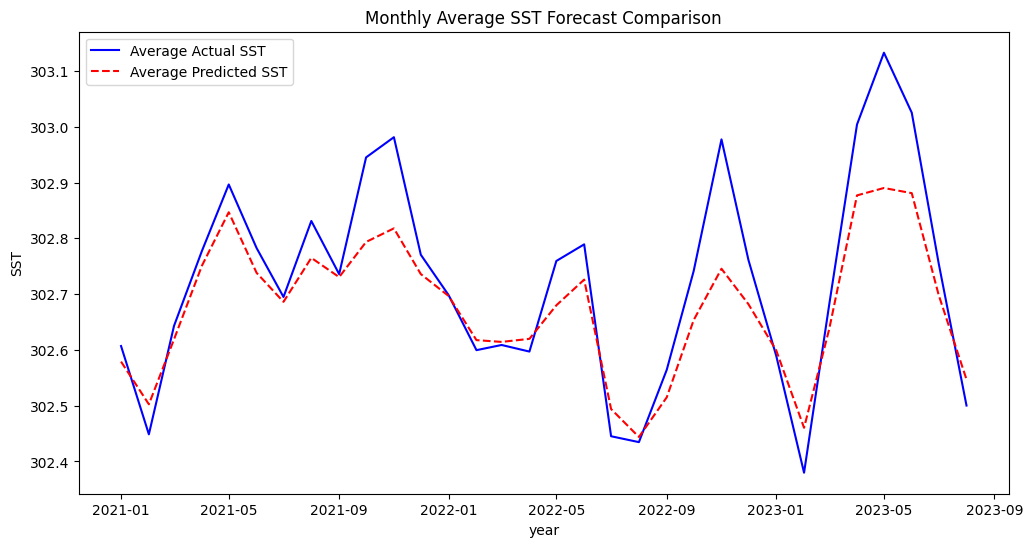

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import mean as _mean, stddev as _std
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(predictions_monthly_pd['year']), predictions_monthly_pd['avg_actual_sst'] , label='Average Actual SST', color='blue')
plt.plot(pd.to_datetime(predictions_monthly_pd['year']), predictions_monthly_pd['avg_prediction'], label='Average Predicted SST', color='red', linestyle='--')
plt.title('Monthly Average SST Forecast Comparison')
plt.xlabel('year')
plt.ylabel('SST')
plt.legend()
plt.show()

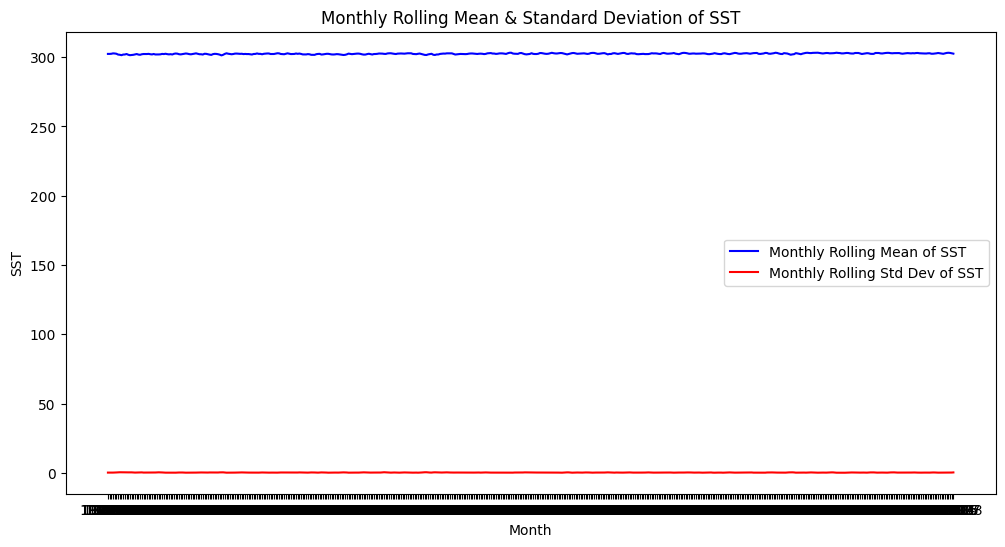

In [0]:
# Use a window specification for rolling operations
from pyspark.sql.window import Window
from pyspark.sql.functions import mean as _mean, stddev as _std

windowSpec = Window.orderBy("time").rowsBetween(-15, 0)  # Adjust the range for appropriate monthly rolling

df = df.withColumn("rolling_mean", _mean("sst").over(windowSpec))
df = df.withColumn("rolling_std", _std("sst").over(windowSpec))

# Aggregate these rolling statistics monthly
df_monthly_stats = df.groupBy(date_format('time', 'yyyy-MM').alias('month')).agg(
    avg('rolling_mean').alias('monthly_rolling_mean'),
    avg('rolling_std').alias('monthly_rolling_std')
).orderBy('month')

df_monthly_stats_pd = df_monthly_stats.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(df_monthly_stats_pd['month'], df_monthly_stats_pd['monthly_rolling_mean'], label='Monthly Rolling Mean of SST', color='blue')
plt.plot(df_monthly_stats_pd['month'], df_monthly_stats_pd['monthly_rolling_std'], label='Monthly Rolling Std Dev of SST', color='red')
plt.title('Monthly Rolling Mean & Standard Deviation of SST')
plt.xlabel('Month')
plt.ylabel('SST')
plt.legend()
plt.show()


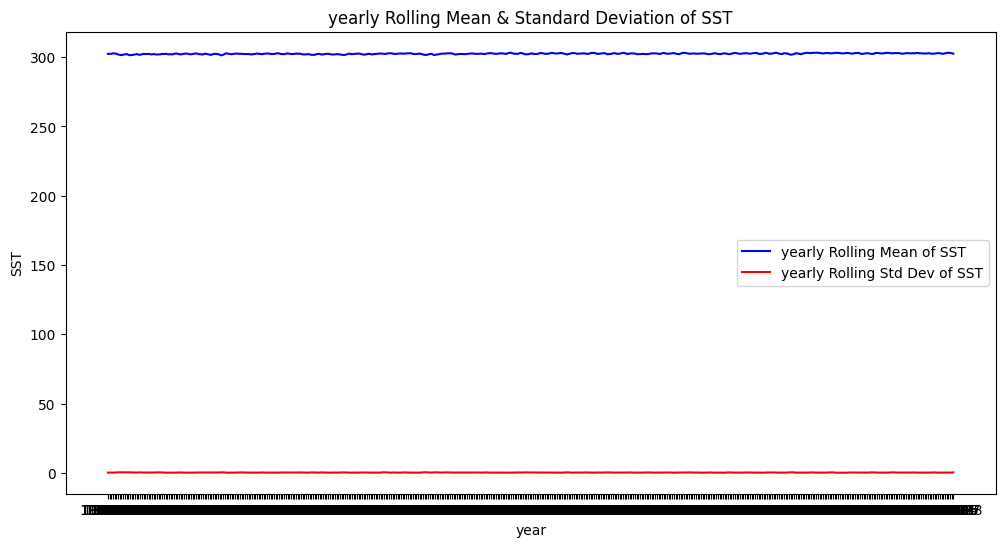

In [0]:
# Use a window specification for rolling operations
from pyspark.sql.window import Window
from pyspark.sql.functions import mean as _mean, stddev as _std

windowSpec = Window.orderBy("time").rowsBetween(-15, 0)  # Adjust the range for appropriate yearly rolling

df = df.withColumn("rolling_mean", _mean("sst").over(windowSpec))
df = df.withColumn("rolling_std", _std("sst").over(windowSpec))

# Aggregate these rolling statistics yearly
df_yearly_stats = df.groupBy(date_format('time', 'yyyy-MM').alias('year')).agg(
    avg('rolling_mean').alias('yearly_rolling_mean'),
    avg('rolling_std').alias('yearly_rolling_std')
).orderBy('year')

df_yearly_stats_pd = df_yearly_stats.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(df_yearly_stats_pd['year'], df_yearly_stats_pd['yearly_rolling_mean'], label='yearly Rolling Mean of SST', color='blue')
plt.plot(df_yearly_stats_pd['year'], df_yearly_stats_pd['yearly_rolling_std'], label='yearly Rolling Std Dev of SST', color='red')
plt.title('yearly Rolling Mean & Standard Deviation of SST')
plt.xlabel('year')
plt.ylabel('SST')
plt.legend()
plt.show()


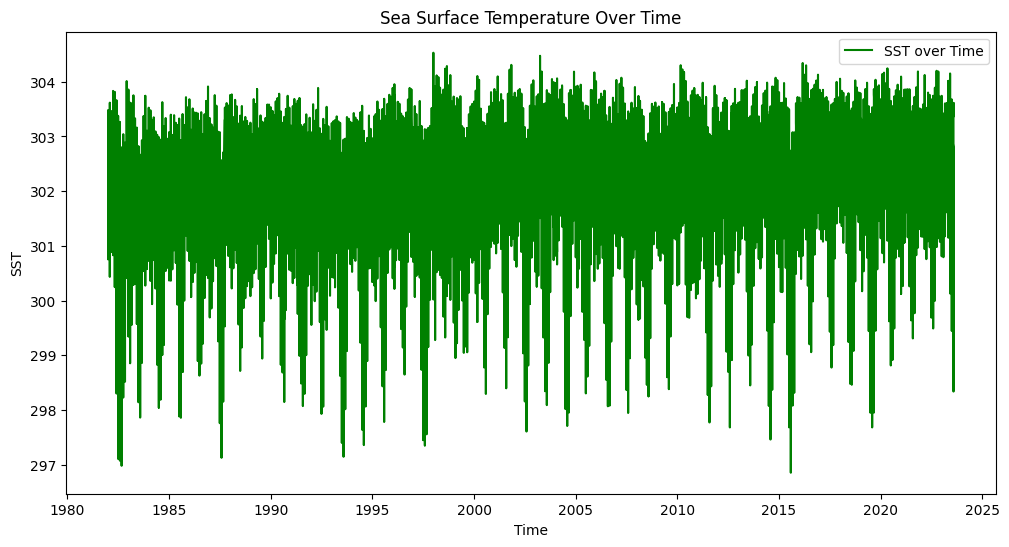

In [0]:
# Assuming you've filtered or sampled the data appropriately
data_sample_pd = df.select("time", "sst").orderBy("time").sample(fraction=0.1).toPandas()  # Sample if the data is too large

plt.figure(figsize=(12, 6))
plt.plot(data_sample_pd['time'], data_sample_pd['sst'], label='SST over Time', color='green')
plt.title('Sea Surface Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('SST')
plt.legend()
plt.show()


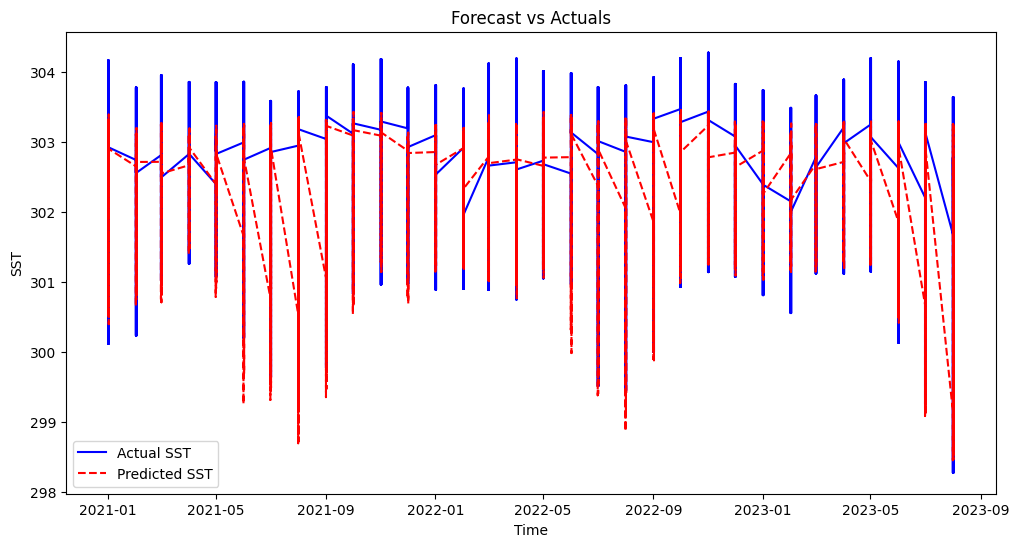

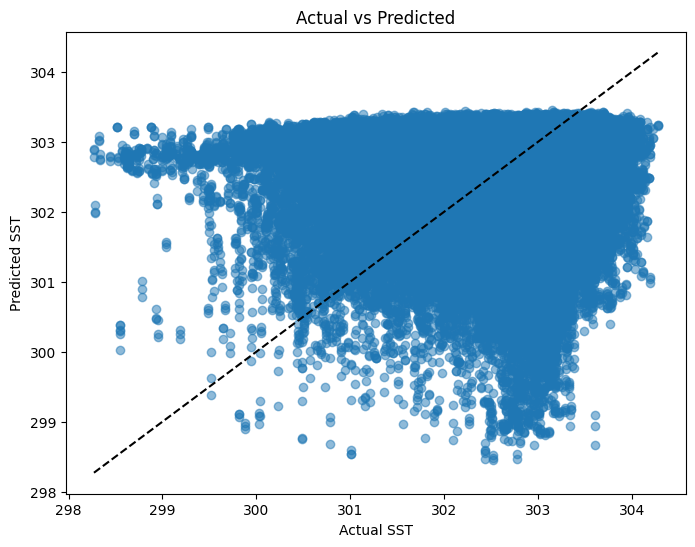

In [0]:
import matplotlib.pyplot as plt

# Collect data from PySpark to local Python for plotting
# Note: Only do this if the dataset is small enough to fit into your driver node's memory.
predictions_pd = predictions.select("time", "prediction").orderBy("time").toPandas()
test_data_pd = test_data.select("time", "sst").orderBy("time").toPandas()

# Plotting the forecast graph
plt.figure(figsize=(12, 6))
plt.plot(test_data_pd['time'], test_data_pd['sst'], label='Actual SST', color='blue')
plt.plot(predictions_pd['time'], predictions_pd['prediction'], label='Predicted SST', color='red', linestyle='--')
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('SST')
plt.legend()
plt.show()

# Plotting Actual vs. Prediction
plt.figure(figsize=(8, 6))
plt.scatter(test_data_pd['sst'], predictions_pd['prediction'], alpha=0.5)
plt.title('Actual vs Predicted')
plt.xlabel('Actual SST')
plt.ylabel('Predicted SST')
plt.plot([test_data_pd['sst'].min(), test_data_pd['sst'].max()], [test_data_pd['sst'].min(), test_data_pd['sst'].max()], 'k--')
plt.show()